# Imports

In [506]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)



import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing


from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV

from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import probplot
import pylab 

from scipy.stats import boxcox
%matplotlib inline
sns.set_theme(palette='colorblind', style='darkgrid')


# Functions

In [507]:
#Function to inverse box_cox transformation 
def box_cox_inverse(variable_trans, lam):
    if lam == 0:
        variable = exp(variable_trans)
    else:
        variable = (variable_trans * lam + 1) ** (1 / lam)
    return variable

# Data importation

In [508]:
df = pd.read_csv('credit_immobilier_ISF.csv')

In [509]:
df.sample(5)

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
462,inconnu,24,bon,auto,2679,< 100 Euro,< 1 annee,1.0,29.0,aucun,proprietaire,1,management,1,oui,non,11171.283960
985,< 0 Euro,11,critique,auto,3939,< 100 Euro,1 - 4 annees,2.0,40.0,aucun,proprietaire,2,non_qualifie,2,oui,non,6488.985874
889,inconnu,15,bon,ameublement,874,inconnu,< 1 annee,1.0,24.0,aucun,proprietaire,1,qualifie,1,oui,non,6268.675907
197,1 - 200 Euro,9,critique,education,1501,< 100 Euro,> 7 annees,3.0,34.0,aucun,proprietaire,2,management,1,oui,oui,3758.552950
987,inconnu,24,bon,auto,7393,< 100 Euro,1 - 4 annees,4.0,43.0,aucun,proprietaire,1,non_qualifie,2,oui,non,11383.516900


#    <h1><center>I - Analyse des données</center></h1>

## 1. Exploration initiale du dataset

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   compte_courant            1021 non-null   object 
 1   duree_emprunt_mois        1021 non-null   int64  
 2   historique_credit         1021 non-null   object 
 3   raison                    1021 non-null   object 
 4   montant                   1021 non-null   int64  
 5   compte_epargne            1020 non-null   object 
 6   duree_emploi              1021 non-null   object 
 7   annees_presence_logement  1018 non-null   float64
 8   age                       1020 non-null   float64
 9   autre_credit              1021 non-null   object 
 10  logement                  1021 non-null   object 
 11  nbre_emprunts_actuels     1021 non-null   int64  
 12  job                       1018 non-null   object 
 13  dependants                1021 non-null   object 
 14  telephon

### Variables numériques

In [511]:
numerical = df.select_dtypes('number')

In [512]:
df.describe()

,duree_emprunt_mois,montant,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,1021.000000,1021.000000,1018.000000,1020.000000,1021.000000,1021.000000
mean,20.770813,3250.088149,2.844794,35.491176,1.409403,12273.073874
std,12.050318,2830.788792,1.104864,11.395078,0.576390,11200.509536
min,4.000000,250.000000,1.000000,19.000000,1.000000,734.476054
25%,12.000000,1352.000000,2.000000,27.000000,1.000000,5192.478646
50%,18.000000,2299.000000,3.000000,33.000000,1.000000,8615.582896
75%,24.000000,3966.000000,4.000000,42.000000,2.000000,15559.590686
max,72.000000,18424.000000,4.000000,75.000000,4.000000,79354.527366


A partir des statistiques descriptives sur les variables numériques, nous ne remarquons pas la présence de valeures aberrantes évidentes.

### Variables catégorielles

In [513]:
categorical = df.select_dtypes('object')

In [514]:
categorical.describe(include=['O'])

,compte_courant,historique_credit,raison,compte_epargne,duree_emploi,autre_credit,logement,job,dependants,telephone,defaillant
count,1021,1021,1021,1020,1021,1021,1021,1018,1021,1021,1020
unique,4,5,6,5,6,4,4,5,3,1,2
top,inconnu,bon,ameublement,< 100 Euro,1 - 4 annees,aucun,proprietaire,qualifie,1,oui,non
freq,402,535,486,611,349,834,731,648,864,1021,717


On remarque que la variable <code>telephone</code> ne prend qu'une seule modalité (oui). Il est donc inutile de garder cette variable.

## 2. Nettoyage des données

In [515]:
#Identification/traitement des variables manquantes
df.isnull().sum(axis=0)

compte_courant              0
duree_emprunt_mois          0
historique_credit           0
raison                      0
montant                     0
compte_epargne              1
duree_emploi                0
annees_presence_logement    3
age                         1
autre_credit                0
logement                    0
nbre_emprunts_actuels       0
job                         3
dependants                  0
telephone                   0
defaillant                  1
revenufinal                 0
dtype: int64

In [516]:
df.loc[df['annees_presence_logement'].isnull(),'annees_presence_logement'] = df['annees_presence_logement'].median()
df.loc[df['job'].isnull(),'job'] = df['job'].value_counts().keys()[0]
df.loc[df['compte_epargne'].isnull(),'compte_epargne'] = df['compte_epargne'].value_counts().keys()[0]

In [517]:
#Enlever les doublons
df = df.drop_duplicates()

In [518]:
#Vérifier toutes les modalités des variables catégoriques pour vérifier les éventuelles erreurs de saisie
for column in categorical.columns:
    print(categorical[column].value_counts())

inconnu         402
< 0 Euro        280
1 - 200 Euro    276
> 200 Euro       63
Name: compte_courant, dtype: int64
bon         535
critique    307
pauvre       89
tres bon     50
parfait      40
Name: historique_credit, dtype: int64
ameublement     486
auto            346
business         97
education        59
renonvations     22
auto0            11
Name: raison, dtype: int64
< 100 Euro         612
inconnu            189
100 - 500 Euro     108
500 - 1000 Euro     64
> 1000 Euro         48
Name: compte_epargne, dtype: int64
1 - 4 annees    349
> 7 annees      260
4 - 7 annees    174
< 1 annee       172
chomeur          65
> 7 annes         1
Name: duree_emploi, dtype: int64
aucun      834
banque     139
magasin     47
2            1
Name: autre_credit, dtype: int64
proprietaire    731
locataire       180
autre           109
qualifie          1
Name: logement, dtype: int64
qualifie        651
non_qualifie    199
management      148
chomeur          22
oui               1
Name: job, dtyp

On remarque que pour les variables <code> dependants</code>, <code> job</code>, <code> logement</code>, <code> autre_credit</code> et <code>duree_emploi</code>, il y a à chaque fois une observation mal renseignée (modalité qui ne correspond pas aux autres modalités). On soupçonne qu'il s'agit de la même ligne. Vérifions cela: 

In [519]:
df.loc[df['duree_emploi'] == '> 7 annes']

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
29,inconnu,7,critique,ameublement,1280,< 100 Euro,> 7 annes,3.0,NaN,2,qualifie,1,oui,oui,oui,NaN,6584.168778


Il s'agit en effet de la même ligne, nous allons donc la supprimer car elle est négligable par rapport au volume total des données.

In [520]:
df = df.drop(29)

In [521]:
# Vérifier qu'il n'y a plus de valeurs manquantes.
df.isnull().sum(axis=0)

compte_courant              0
duree_emprunt_mois          0
historique_credit           0
raison                      0
montant                     0
compte_epargne              0
duree_emploi                0
annees_presence_logement    0
age                         0
autre_credit                0
logement                    0
nbre_emprunts_actuels       0
job                         0
dependants                  0
telephone                   0
defaillant                  0
revenufinal                 0
dtype: int64

## 3. Analyse univariée

In [522]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('object')

### Variables numériques

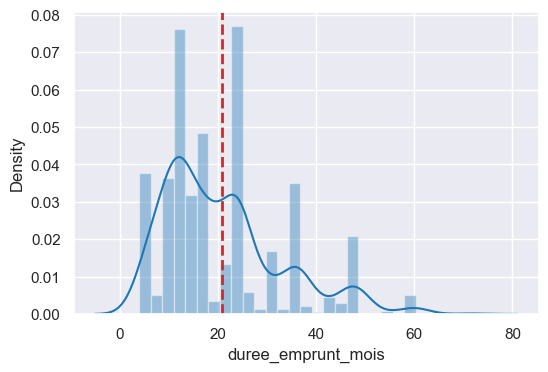

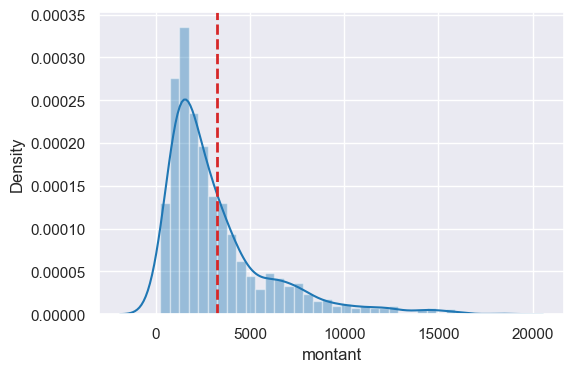

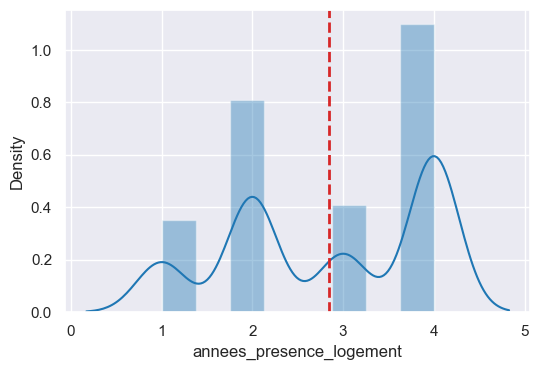

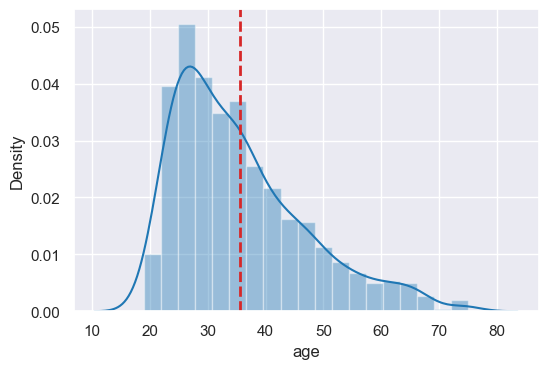

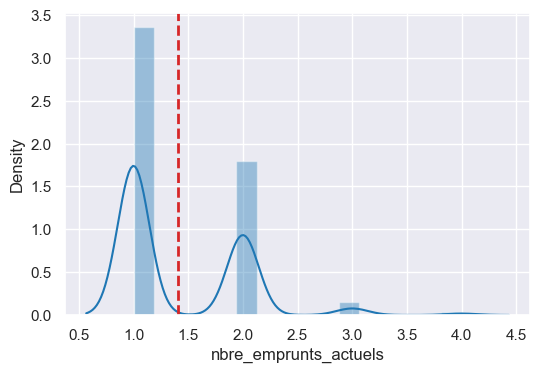

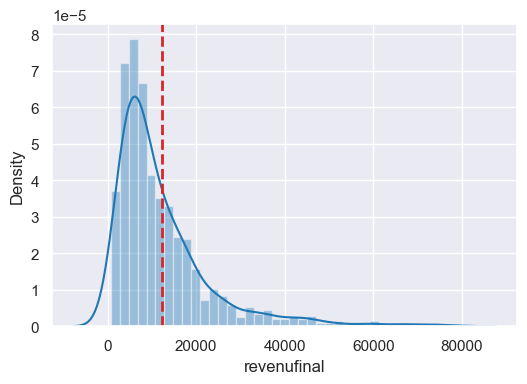

In [523]:
for variable in numerical.columns:  
    plt.figure(dpi=100)
    sns.distplot(numerical[variable], color='tab:blue')
    plt.axvline(x=numerical[variable].mean(), color='tab:red', linestyle='--', linewidth=2);


<li> La variable à prédire est <code> montant</code>. On remarque que sa distribution est asymétrique. Il va falloir faire une transformation pour enlever la skewness. On va la transformer à l'aide de la fonction <code>boxcox</code> car les valeurs prises sont positives (minimum à 250). Cette fonction permet de retrouver facilement le format à l'origine de la variable après la prédiction.
<li> Nous pouvons faire une transformation pour les variables <code>age</code> et <code>revenufinal</code> car elles ont le même problème. Nous pouvons par exemple prendre le log.
<li> Le reste des variables sont discrètes et ne nécessitent pas de transformation particulière.
    
    
    
    
    
    
    
    
    

    

### Variables catégorielles

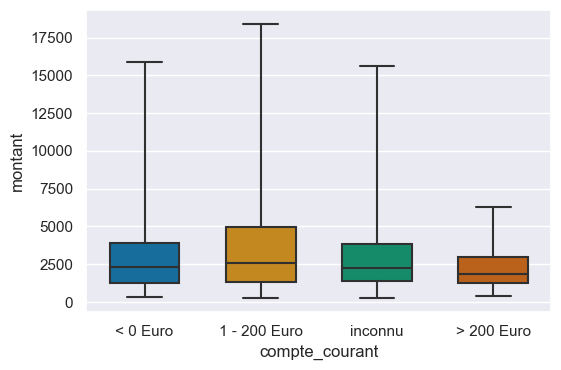

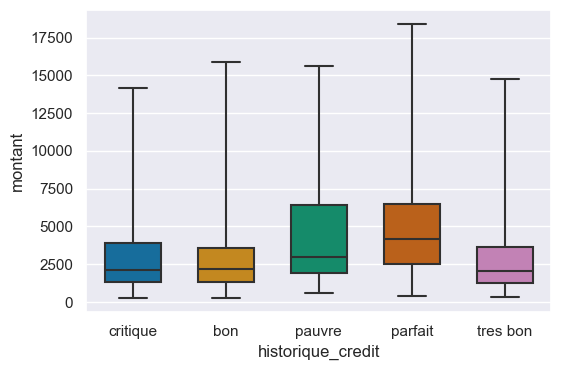

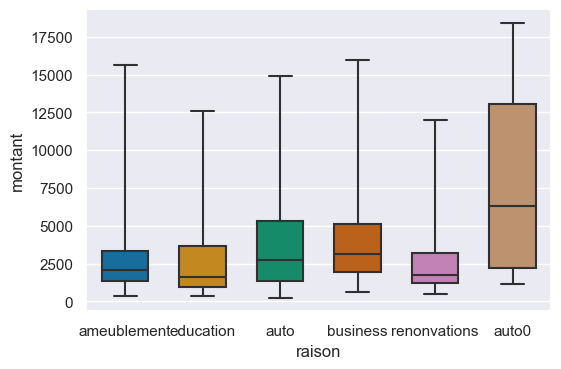

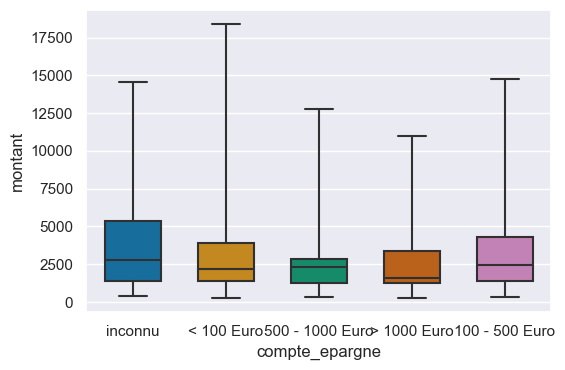

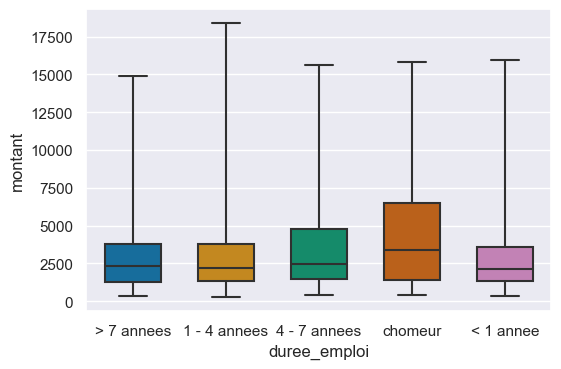

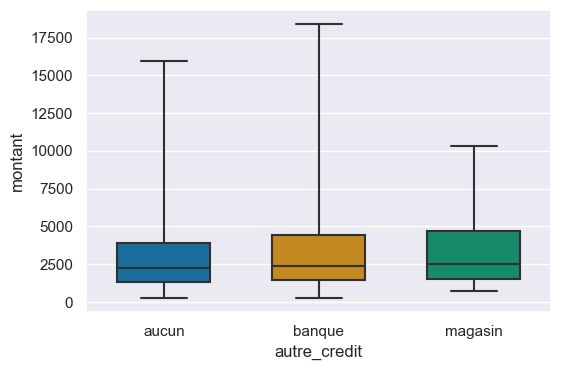

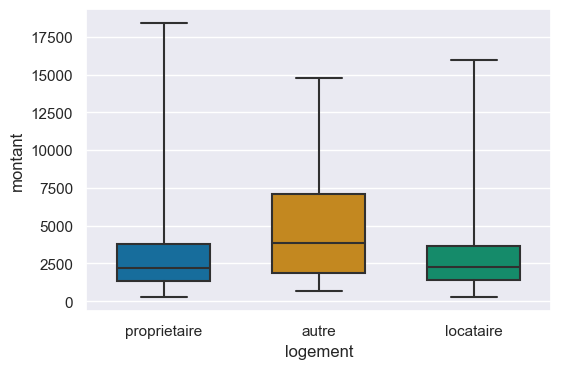

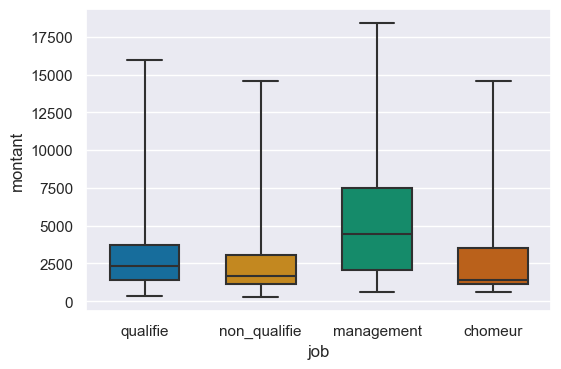

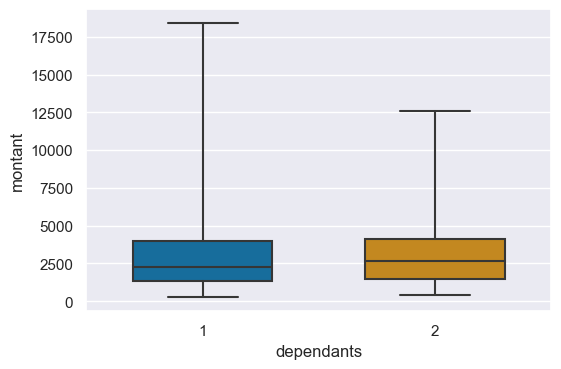

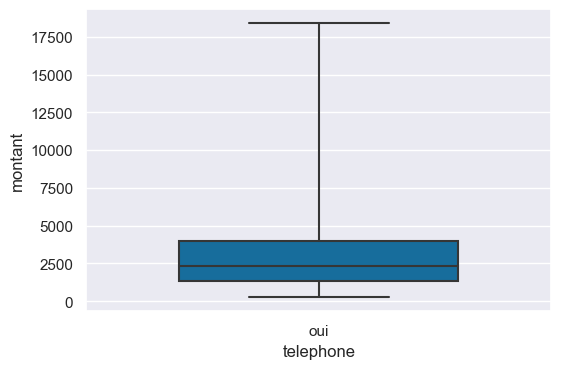

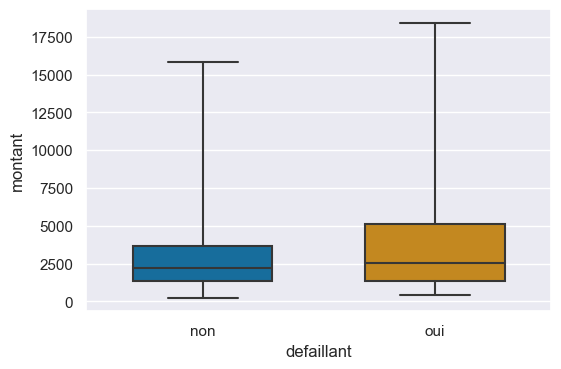

In [524]:
for variable in categorical.columns:
    plt.figure(dpi=100)
    sns.boxplot(x=variable, y="montant", data=df,
            whis=[0, 100], width=.6)

Aucune modalité ne semble dominer les autres dans aucunes des variables. Nous allons donc les garder ainsi.

## 4. Analyse bivariée

### Variables numériques

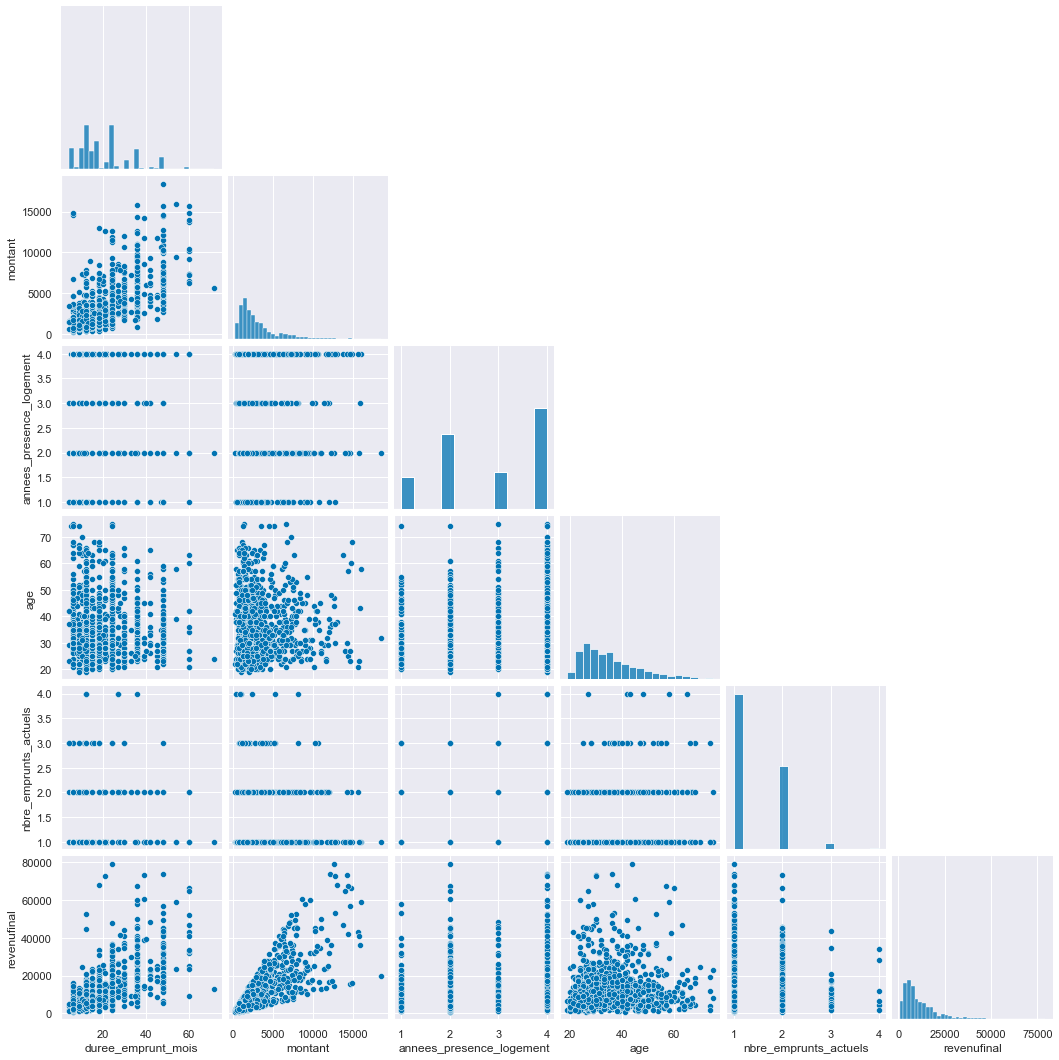

In [525]:
sns.pairplot(numerical, corner=True);

### Variables catégorielles

<Figure size 600x400 with 0 Axes>

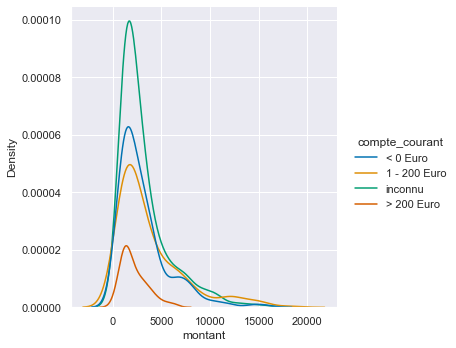

<Figure size 600x400 with 0 Axes>

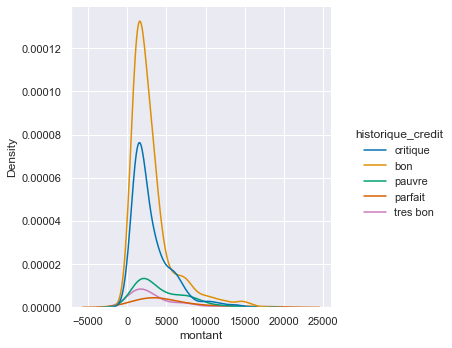

<Figure size 600x400 with 0 Axes>

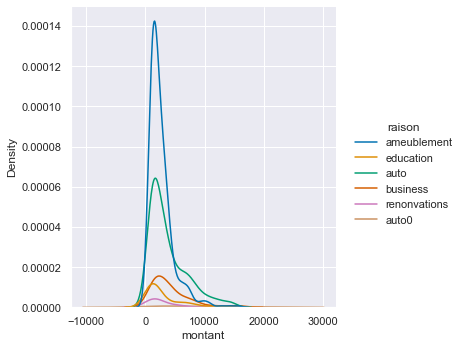

<Figure size 600x400 with 0 Axes>

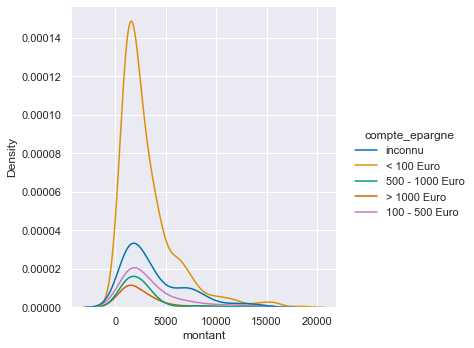

<Figure size 600x400 with 0 Axes>

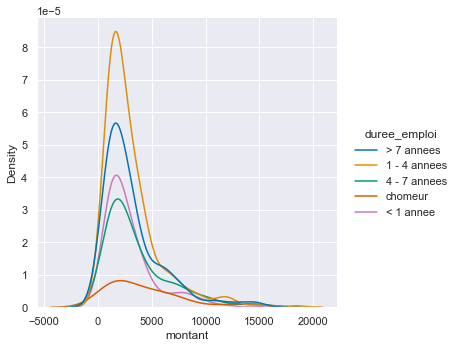

<Figure size 600x400 with 0 Axes>

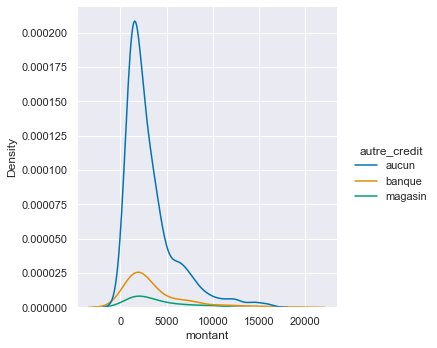

<Figure size 600x400 with 0 Axes>

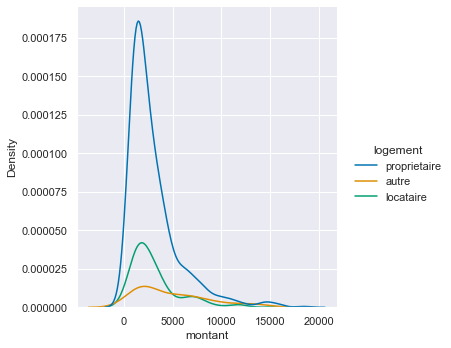

<Figure size 600x400 with 0 Axes>

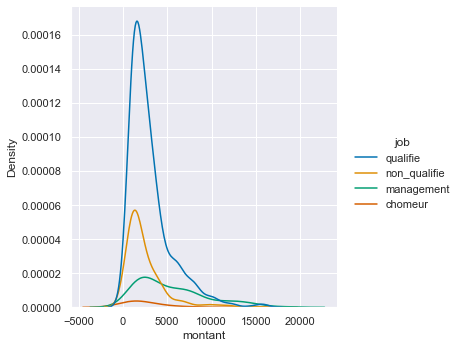

<Figure size 600x400 with 0 Axes>

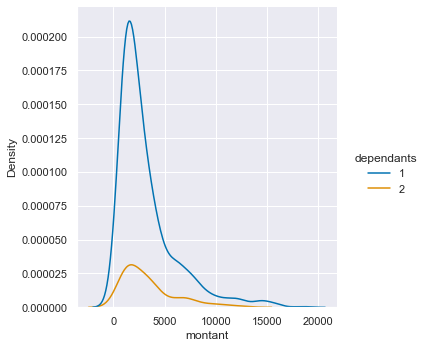

<Figure size 600x400 with 0 Axes>

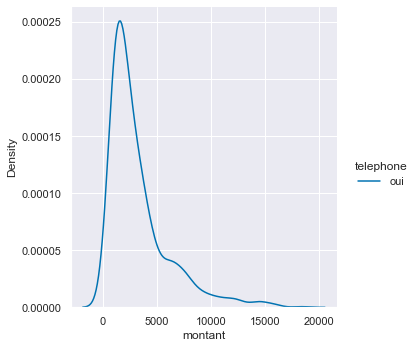

<Figure size 600x400 with 0 Axes>

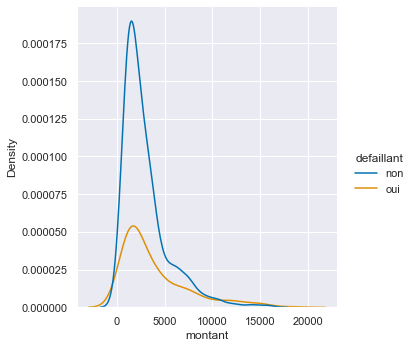

In [526]:
for variable in categorical.columns:
    plt.figure(dpi=100)

    sns.displot(df, x='montant', hue=variable,fill=False, kind='kde')
    plt.show()

## 5. Analyse multivariée

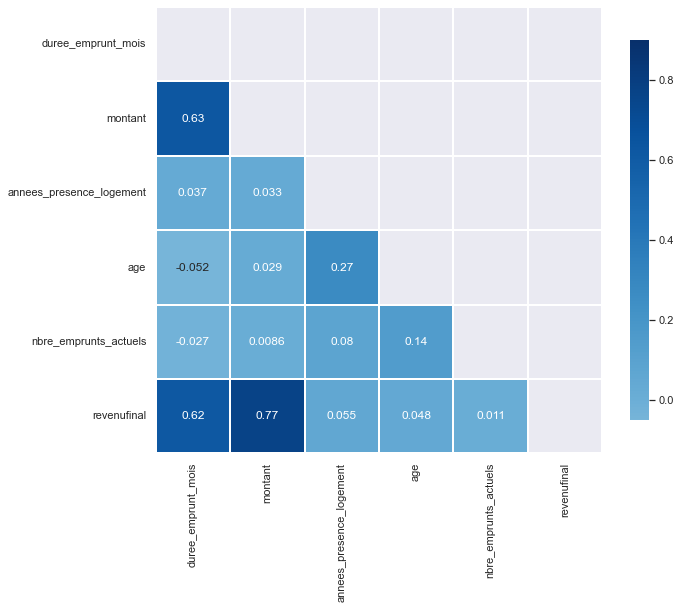

In [527]:
# corr = df.corr(method = 'spearman')
corr = df.corr(method = 'pearson')
fig, ax = plt.subplots(figsize = (10,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, vmax = 0.9, cmap='Blues', square = True, annot = True, linewidths=2, 
            linecolor = 'white', cbar_kws={"shrink": .7}, center=0);

<li> On remarque que les deux variables <code>revenufinal</code> et <code>duree_emprunt_mois</code> sont très corrélées à la target <code>montant</code> donc sont probablement très significatives.

## 6. Feature engineering

In [528]:
# Transformation des variable à l'aide de boxcox
df["montant_bc"], lam_1 = boxcox(df["montant"])
df["age_bc"], lam_2 = boxcox(df["age"])
df["revenufinal_bc"], lam_3 = boxcox(df["revenufinal"])

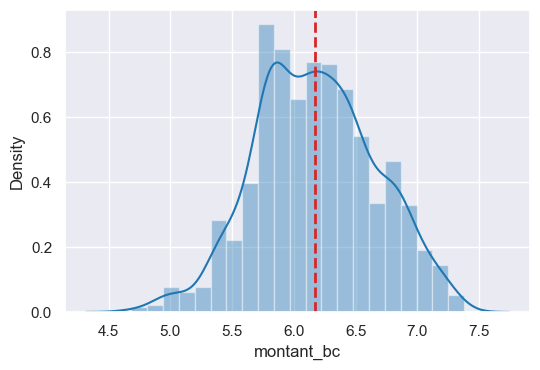

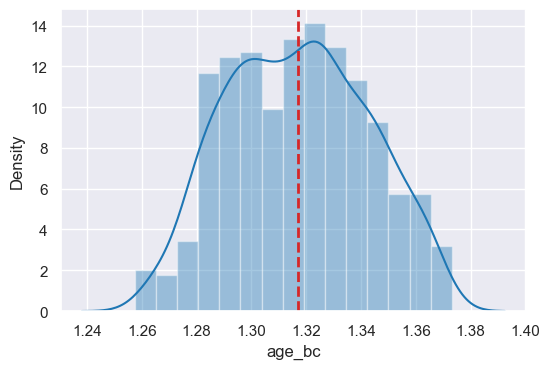

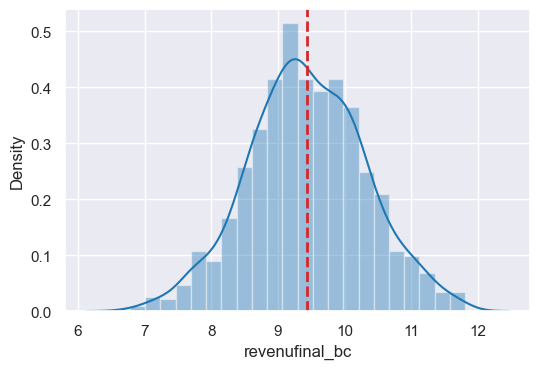

In [529]:
#Vérification boxcox transformation 
variables = ['montant_bc', 'age_bc', 'revenufinal_bc']  
for variable in variables:  
    plt.figure(dpi=100)
    sns.distplot(df[variable], color='tab:blue')
    plt.axvline(x=df[variable].mean(), color='tab:red', linestyle='--', linewidth=2);

Nous remarquons que la transformation <code>boxcox</code> permet bien de réduire l'asymétrie des variables. 

In [530]:
# Supprimer variable telephone car ne contient qu'une seule modalité
df = df.drop('telephone', axis=1)

#Supprimer variables transformées par boxcox 
df = df.drop(['age','revenufinal','montant'], axis=1)

## 7. Encodage des variables 

In [531]:
# Ordinal encoding historique_credit parce que les modalités représentent dees niveaux ordonnés 

df.loc[df['historique_credit']=='critique', 'historique_credit'] = 0
df.loc[df['historique_credit']=='pauvre', 'historique_credit'] = 1
df.loc[df['historique_credit']=='bon', 'historique_credit'] = 2
df.loc[df['historique_credit']=='tres bon', 'historique_credit'] = 3
df.loc[df['historique_credit']=='parfait', 'historique_credit'] = 4

df['historique_credit'] = df['historique_credit'].astype(int)

# On "One hot encode" le reste des variables catégorielles pour la modélisation 
df = pd.get_dummies(df, drop_first=True)

#    <h1><center>II - Modélisation</center></h1>

In [532]:
# Préparation des données pour la modélisation

X = df.drop(columns=['montant_bc'])
y = df[['montant_bc']]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Régression linéaire

In [533]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)
y_pred = y_pred.flatten(order='C')

print(f'mse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=True)}')
print(f'rmse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=False)}')
print(f'R2 score = {r2_score(y_test, y_pred)}')
print(f'R2 adjusted score = {1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))}')

mse = 3957619.4002430188
rmse = 1989.3766360955933
R2 score = 0.6331248827208669
R2 adjusted score = 0.5916171139776073


###  Régularisation

In [534]:
#Mise à échelle
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Ridge

### 2. Alpha optimal

In [535]:
n_alphas = 300
alphas = np.logspace(-5, 10, n_alphas)

In [536]:
ridge = Ridge()

coefs = []
errors = []
errorstrain = []
r2 = []
r2train = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_s, y_train)
    coefs.append((ridge.coef_).flatten(order='C'))
    errors.append(np.mean((ridge.predict(X_test_s) - y_test) ** 2))
    errorstrain.append(np.mean((ridge.predict(X_train_s) - y_train) ** 2)) 
    r2.append(r2_score(y_test, ridge.predict(X_test_s)))
    r2train.append(r2_score(y_train, ridge.predict(X_train_s)))

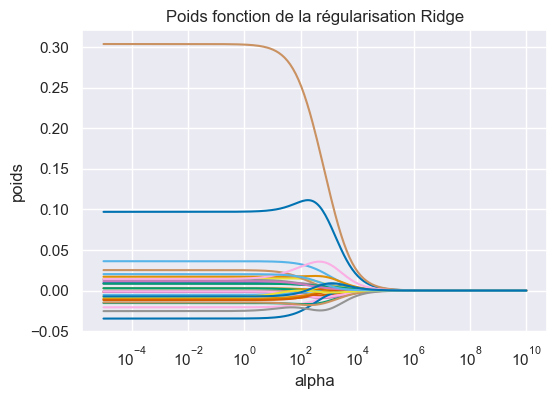

In [537]:
# affichage de l'evolution de la valeur des poids en fonction des différents alpha

plt.figure(dpi=100)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Poids fonction de la régularisation Ridge')
#plt.axis('tight')
plt.show()

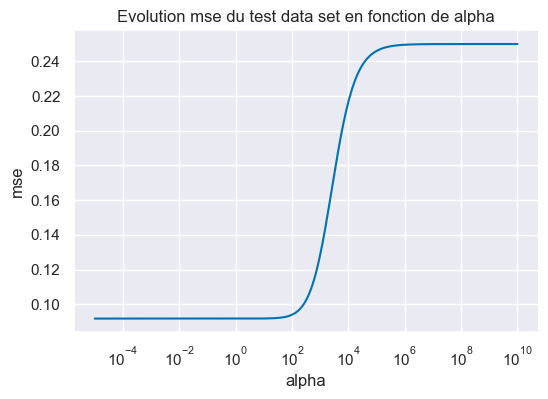

In [538]:
# évolution du mse en fonction de alpha
plt.figure(dpi=100)
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.axis('tight')
plt.title('Evolution mse du test data set en fonction de alpha')
plt.show()

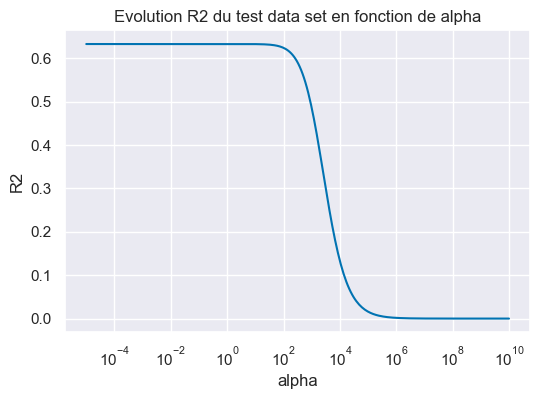

In [539]:
# évolution du R2 fonction de alpha
plt.figure(dpi=100)
ax = plt.gca()

ax.plot(alphas, r2)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.axis('tight')
plt.title('Evolution R2 du test data set en fonction de alpha')

plt.show()

In [540]:
### Ridge Cross Validation pour le meilleur aloha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True,cv=3)
ridgecv.fit(X_train_s, y_train)
best_alpha = ridgecv.alpha_

In [541]:
best_alpha

0.05788177037701274

In [542]:
ridge = Ridge(alpha=best_alpha, normalize=True)
ridge = ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
y_train_pred = ridge.predict(X_train)

#Metriques de performance
print(f'mse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=True)}')
print(f'rmse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=False)}')
print(f'R2 score = {r2_score(y_test, y_pred)}')
print(f'R2 adjusted score = {1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))}')

mse = 4051282.4267858444
rmse = 2012.779776027632
R2 score = 0.6308737331050697
R2 adjusted score = 0.5891112722519936


In [543]:
# Coefficients des features
pd.Series((ridge.coef_).flatten(order='C'), index = X.columns)

duree_emprunt_mois                0.008713
historique_credit                 0.002177
annees_presence_logement          0.001361
nbre_emprunts_actuels            -0.001482
age_bc                            0.342332
revenufinal_bc                    0.313552
compte_courant_< 0 Euro          -0.040658
compte_courant_> 200 Euro        -0.007584
compte_courant_inconnu            0.030723
raison_auto                       0.072819
raison_auto0                      0.082901
raison_business                   0.057642
raison_education                 -0.072665
raison_renonvations              -0.065894
compte_epargne_500 - 1000 Euro   -0.017143
compte_epargne_< 100 Euro         0.041407
compte_epargne_> 1000 Euro       -0.017813
compte_epargne_inconnu            0.028288
duree_emploi_4 - 7 annees        -0.011477
duree_emploi_< 1 annee           -0.009887
duree_emploi_> 7 annees          -0.069005
duree_emploi_chomeur             -0.032681
autre_credit_banque               0.023197
autre_credi

# Lasso

In [544]:
n_alphas = 300
alphas = np.logspace(-5, 10, n_alphas)

In [545]:
lasso = Lasso(fit_intercept=True)

coefs = []
errors = []
errorstrain = []
r2 = []
r2train = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_s, y_train)
    coefs.append((lasso.coef_).flatten(order='C'))
    errors.append(np.mean(((lasso.predict(X_test_s)).reshape(306,1) - y_test) ** 2))
    errorstrain.append(np.mean((lasso.predict(X_train_s).reshape(714,1) - y_train) ** 2)) 
    r2.append(r2_score(y_test, lasso.predict(X_test_s)))
    r2train.append(r2_score(y_train, lasso.predict(X_train_s)))

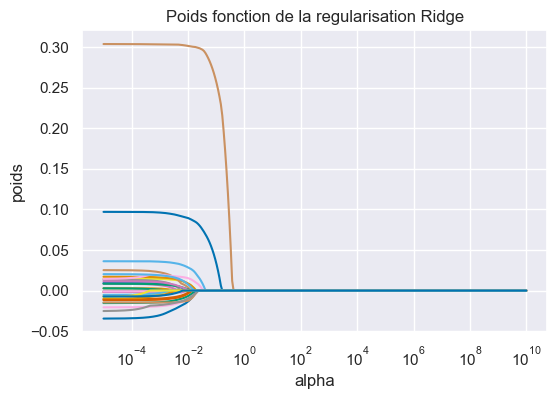

In [546]:
# affichage evolution de la valeur des poids 
plt.figure(dpi=100)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.title('Poids fonction de la regularisation Ridge')
#plt.axis('tight')
plt.show()

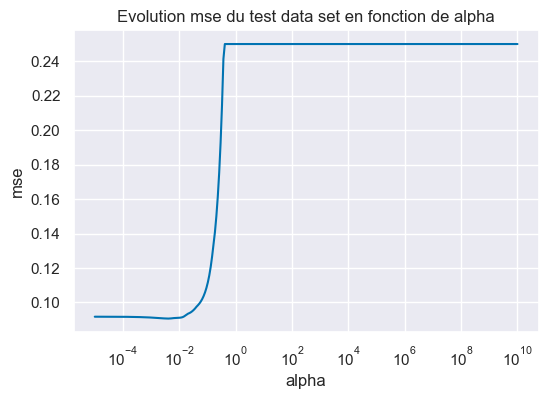

In [547]:
# évolution mse fonction de alpha
plt.figure(dpi=100)
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.axis('tight')
plt.title('Evolution mse du test data set en fonction de alpha')
plt.show()

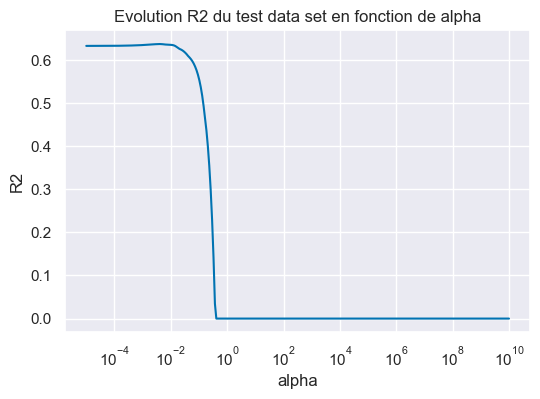

In [548]:
# évolution du R2 fonction de alpha
plt.figure(dpi=100)
ax = plt.gca()

ax.plot(alphas, r2)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.axis('tight')
plt.title('Evolution R2 du test data set en fonction de alpha')

plt.show()

In [549]:
### Ridge Cross Validation pour le meilleur aloha
lassocv = LassoCV(alphas=alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)
lassocv.fit(X, y)
best_alpha = lassocv.alpha_

In [550]:
best_alpha

0.001611973357388157

In [551]:
lasso = Lasso(alpha=best_alpha, normalize=True)
lasso = lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
y_train_pred = lasso.predict(X_train)

#Metriques de performance
print(f'mse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=True)}')
print(f'rmse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=False)}')
print(f'R2 score = {r2_score(y_test, y_pred)}')
print(f'R2 adjusted score = {1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))}')

mse = 4442598.819878846
rmse = 2107.7473330261496
R2 score = 0.6082713890958794
R2 adjusted score = 0.5639517287381139


In [552]:
# Coefficients des features
pd.Series((lasso.coef_).flatten(order='C'), index = X.columns)

duree_emprunt_mois                0.005689
historique_credit                 0.000000
annees_presence_logement         -0.000000
nbre_emprunts_actuels             0.000000
age_bc                            0.000000
revenufinal_bc                    0.327829
compte_courant_< 0 Euro          -0.000000
compte_courant_> 200 Euro        -0.000000
compte_courant_inconnu            0.000000
raison_auto                       0.000000
raison_auto0                      0.000000
raison_business                   0.000000
raison_education                 -0.000000
raison_renonvations              -0.000000
compte_epargne_500 - 1000 Euro   -0.000000
compte_epargne_< 100 Euro         0.000000
compte_epargne_> 1000 Euro       -0.000000
compte_epargne_inconnu            0.000000
duree_emploi_4 - 7 annees         0.000000
duree_emploi_< 1 annee           -0.000000
duree_emploi_> 7 annees          -0.000000
duree_emploi_chomeur              0.000000
autre_credit_banque               0.000000
autre_credi

# Elastic Net 

In [553]:
# Paramètre par défaut
ElNet = ElasticNet()
ElNet = ElNet.fit(X_train, y_train)
y_pred = ElNet.predict(X_test)
y_train_pred = ElNet.predict(X_train)
print(f'mse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=True)}')
print(f'rmse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=False)}')
print(f'R2 score = {r2_score(y_test, y_pred)}')
print(f'R2 adjusted score = {1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))}')

mse = 6004249.087173229
rmse = 2450.3569305660817
R2 score = 0.41139285928239877
R2 adjusted score = 0.3447986207340571


In [554]:
lambda_1 = 0.0578
lambda_2 = 0.0016

In [555]:
ElNet = ElasticNet(alpha = lambda_1 + lambda_2 , l1_ratio = lambda_1/(lambda_1 + lambda_2))
ElNet = ElNet.fit(X_train, y_train)
y_pred = ElNet.predict(X_test)
y_train_pred = ElNet.predict(X_train)

print(f'mse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=True)}')
print(f'rmse = {mean_squared_error(box_cox_inverse(y_test,lam_1), box_cox_inverse(y_pred,lam_1), squared=False)}')
print(f'R2 score pour le train = {r2_score(y_train, y_train_pred)}')
print(f'R2 score pour le test = {r2_score(y_test, y_pred)}')
print(f'R2 adjusted score = {1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))}')

mse = 4428477.216071918
rmse = 2104.394738653354
R2 score pour le train = 0.6222874525453687
R2 score pour le test = 0.5994936711671345
R2 adjusted score = 0.5541809113356789


Il semblerait que le modèle permettant de maximiser la métrique R2 est la régression linéaire (non-régularisée), nous allons donc choisir ce modèle. Attention, il faudrait probablement regarder d'autres métriques pour comparer tous les modèles (rmse à minimiser et R2 score ajustés car Lasso et Elastic Net font de la sélection de variables, nous n'avons donc plus les mêmes dimensions..)

# Sélection automatique des features par récursivité

In [556]:
rfecv = RFECV(estimator=LinearRegression())

In [557]:
pipe = Pipeline([('Feature Selection', rfecv), ('Model', lr)])
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=0)

In [558]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection', RFECV(estimator=LinearRegression())),
                ('Model', LinearRegression())])

In [559]:
#Nombre optimal de variables à garder
print("Nombre optimal de variables : %d" % rfecv.n_features_)

Nombre optimal de variables : 28


In [560]:
#Rang des variables 
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df

,Rank
duree_emprunt_mois,1
job_qualifie,1
job_non_qualifie,1
job_management,1
logement_proprietaire,1
logement_locataire,1
autre_credit_magasin,1
autre_credit_banque,1
duree_emploi_chomeur,1
duree_emploi_> 7 annees,1


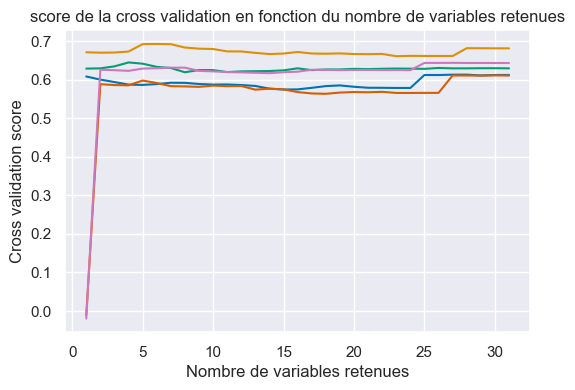

In [561]:
plt.figure(dpi=100)
plt.xlabel("Nombre de variables retenues")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title('score de la cross validation en fonction du nombre de variables retenues')
plt.show()

# Hypothèse régression linéaire avec les features séléctionnée

In [562]:
X_train = X_train[['duree_emprunt_mois', 'job_qualifie', 'job_non_qualifie',
       'job_management', 'logement_proprietaire', 'logement_locataire',
       'autre_credit_magasin', 'autre_credit_banque', 'duree_emploi_chomeur',
       'duree_emploi_> 7 annees', 'duree_emploi_< 1 annee',
       'duree_emploi_4 - 7 annees', 'compte_epargne_inconnu',
       'compte_epargne_> 1000 Euro', 'dependants_2',
       'compte_epargne_< 100 Euro', 'raison_renonvations', 'raison_education',
       'raison_business', 'raison_auto0', 'raison_auto',
       'compte_courant_inconnu', 'compte_courant_< 0 Euro', 'revenufinal_bc',
       'age_bc', 'nbre_emprunts_actuels', 'compte_epargne_500 - 1000 Euro',
       'defaillant_oui', 'compte_courant_> 200 Euro', 'historique_credit',
       'annees_presence_logement']]

In [563]:
df_train = pd.concat([X_train, y_train], axis=1)

In [564]:
#Fit de la régression linéaire sur nos données d'entrainement
model = sm.OLS(y_train, X_train)
model_fit = model.fit()

On souhaite vérifier si les hypothèses de la régression linéaire sont validées:

### 1. Hypothèse 1: "Les erreurs sont centrées"

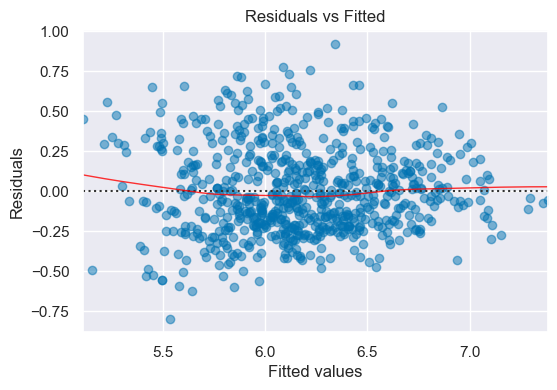

In [565]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure(dpi=100)
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, df_train.columns[-1], data=df_train,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

Les points sont répartis de part et d'autre de 0 sans tendance particulière, les erreurs sont donc centrées et l'hypothèse 1 est vérifiée.

### 2. Hypothèse 2: "Les erreurs sont de variance constante" (homoscédasticité)

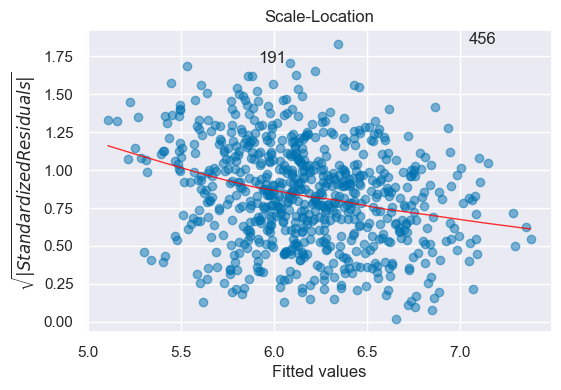

In [566]:
plot_lm_3 = plt.figure(dpi=100)
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:2]
for i in abs_sq_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));

La courbe rouge est décroissante, l'hypothèse d'homoscédasticité n'est pas vérifiée.

### Hypothèse 3: "Les erreurs sont supposées indépendantes"

In [567]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             montant_bc   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.128e+04
Date:                Sun, 08 May 2022   Prob (F-statistic):                        0.00
Time:                        23:41:51   Log-Likelihood:                         -87.298
No. Observations:                 714   AIC:                                      236.6
Df Residuals:                     683   BIC:                                      378.3
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
duree_emprunt_mois                 0.0083      0.001      6.817      0.000       0.006       0.011
job_qualifie                       0.0344      0.080      0.427      0.669      -0.124       0.192
job_non_qualifie                  -0.0248      0.084     -0.296      0.767      -0.189       0.140
job_management                     0.0713      0.081      0.876      0.382      -0.089       0.231
logement_proprietaire             -0.0100      0.038     -0.266      0.791      -0.084       0.064
logement_locataire                 0.0728      0.043      1.689      0.092      -0.012       0.157
autre_credit_magasin              -0.0571      0.051     -1.123      0.262      -0.157       0.043
autre_credit_banque                0.0204      0.032      0.629      0.530      -0.043       0.084
duree_emploi_chomeur              -0.0405      0.055     -0.741      0.459      -0.148       0.067
duree_emploi_> 7 annees           -0.1061      0.030     -3.515      0.000      -0.165      -0.047
duree_emploi_< 1 annee            -0.0032      0.032     -0.099      0.921      -0.066       0.060
duree_emploi_4 - 7 annees         -0.0204      0.032     -0.637      0.525      -0.083       0.043
compte_epargne_inconnu             0.0320      0.043      0.740      0.459      -0.053       0.117
compte_epargne_> 1000 Euro        -0.0153      0.063     -0.242      0.809      -0.139       0.108
dependants_2                       0.0460      0.031      1.490      0.137      -0.015       0.107
compte_epargne_< 100 Euro          0.0516      0.037      1.378      0.169      -0.022       0.125
raison_renonvations               -0.0868      0.074     -1.175      0.240      -0.232       0.058
raison_education                  -0.0788      0.049     -1.597      0.111      -0.176       0.018
raison_business                    0.0419      0.039      1.087      0.277      -0.034       0.118
raison_auto0                       0.0986      0.112      0.877      0.381      -0.122       0.319
raison_auto                        0.0686      0.025      2.750      0.006       0.020       0.118
compte_courant_inconnu             0.0278      0.029      0.971      0.332      -0.028       0.084
compte_courant_< 0 Euro           -0.0451      0.030     -1.501      0.134      -0.104       0.014
revenufinal_bc                     0.3474      0.017     20.738      0.000       0.315       0.380
age_bc                             2.0152      0.133     15.101      0.000       1.753       2.277
nbre_emprunts_actuels             -0.0011      0.022     -0.053      0.958      -0.044       0.042
compte_epargne_500 - 1000 Euro    -0.0077      0.056     -0.137      0.891      -0.117       0.102
defaillant_oui

À l'aide du test de Durbin Watson dont la valeur est égale à 2.026, on déduit qu'il n'y a pas de corrélation entre les résidus. L'hypothèse est donc vérifiée.

### Hypothèse 4: "Les erreurs sont supposées gaussiennes"

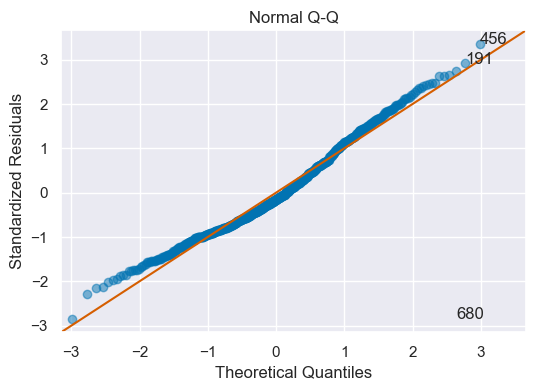

In [568]:
QQ = ProbPlot(model_norm_residuals)
with plt.rc_context():
    plt.rc("figure", dpi=100)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]


    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                    model_norm_residuals[i]));                      

Les points sont alignés tout au long de la première bissectrice, l'hypothèse de normalité est vérifiée.